In [31]:
# PROJECT 1 — Customer Churn Prediction

# Problem: “Which customers are likely to leave next month?”
# Resources: Features: monthly usage, support calls, tenure (months with company) 

# Step 1 — Create Dataset
import numpy as np
import pandas as pd

np.random.seed(42)

n = 1000

usage = np.random.normal(50, 15, n)
support_calls = np.random.randint(0, 10, n)
tenure = np.random.randint(1, 60, n)

churn = ((usage < 40) & (support_calls > 5) | (tenure < 6)).astype(int)

df = pd.DataFrame({
    "usage": usage,
    "support_calls": support_calls,
    "tenure": tenure,
    "churn": churn
})

df.head()



,usage,support_calls,tenure,churn
0,57.450712,6,40,0
1,47.926035,0,21,0
2,59.715328,7,15,0
3,72.845448,2,22,0
4,46.487699,5,52,0


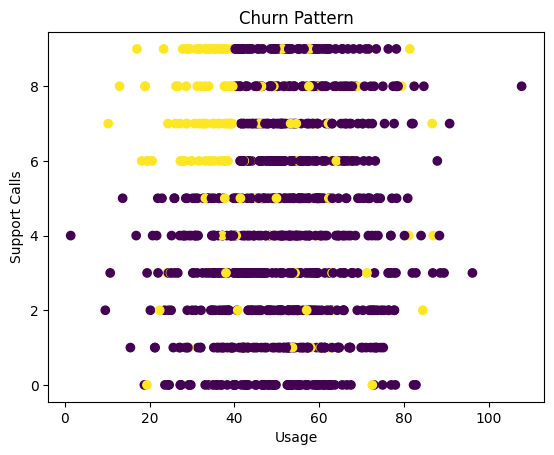

In [32]:
# Step 2 — Visualize to Gain Insight(EDA)

import matplotlib.pyplot as plt

plt.scatter(df["usage"], df["support_calls"], c=df["churn"])
plt.xlabel("Usage")
plt.ylabel("Support Calls")
plt.title("Churn Pattern")
plt.show()

# Insight you’ll see:
# low usage + high complaints cluster near churn


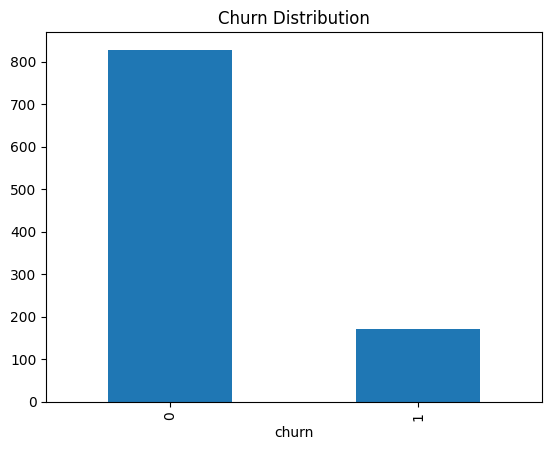

In [33]:
# Step 3 — Check Imbalance

df["churn"].value_counts().plot(kind="bar")
plt.title("Churn Distribution")
plt.show()



In [34]:
# Step 4 — Handle Imbalance (Oversampling)

from sklearn.utils import resample

majority = df[df.churn == 0]
minority = df[df.churn == 1]

minority_upsampled = resample(minority,
                              replace=True,
                              n_samples=len(majority),
                              random_state=42)

df_balanced = pd.concat([majority, minority_upsampled])


In [ ]:
# Step 5 — Train Classifier

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Add some noise, to make learning efficient
noise_mask = np.random.random(len(df_balanced)) < 0.15
df_balanced["churn"] = np.where(noise_mask, 1 - df_balanced["churn"], df_balanced["churn"])

X = df_balanced[["usage", "support_calls", "tenure"]]
y = df_balanced["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [36]:
# Step 6 — Evaluate Performance

from sklearn.metrics import classification_report

preds = model.predict(X_test)
print(classification_report(y_test, preds))

# Focus on:
# recall for churn
# F1 score

              precision    recall  f1-score   support

           0       0.75      0.70      0.73       270
           1       0.67      0.72      0.70       227

    accuracy                           0.71       497
   macro avg       0.71      0.71      0.71       497
weighted avg       0.71      0.71      0.71       497



In [ ]:
# Step 7 — Business Interpretation

# If recall = 0.72:

# Means:
# We catch 72% of customers likely to leave.
#   —Marketing can now:
#   —give discounts
#   —call high-risk customers

In [ ]:
# Step 8 # Metrics of all models

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import pandas as pd

# 1. Define the models
models = [
    ("LogReg", LogisticRegression(max_iter=1000)),
    ("DecTree", DecisionTreeClassifier(random_state=42)),
    ("RandomForest", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("GradBoost", GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ("SVM", SVC())
]

# 2. Set up cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

# 3. Define the scoring metrics
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']

# 4. Create a list to store results
comparison_list = []

for name, model in models:
    # cross_validate returns a dictionary of results
    cv_results = cross_validate(model, X, y, cv=skf, scoring=scoring_metrics)
    
    # Calculate means for each metric
    comparison_list.append({
        "Model": name,
        "Accuracy": cv_results['test_accuracy'].mean(),
        "Precision": cv_results['test_precision'].mean(),
        "Recall": cv_results['test_recall'].mean(),
        "F1-Score": cv_results['test_f1'].mean()
    })

# 5. Display as a clean Pandas DataFrame
comparison_df = pd.DataFrame(comparison_list)

# Formatting the output to look like a table
print("--- Model Performance Comparison Table ---")
print(comparison_df.to_string(index=False))


--- Model Performance Comparison Table ---
       Model  Accuracy  Precision   Recall  F1-Score
      LogReg  0.702293   0.691077 0.703458  0.696918
     DecTree  0.764503   0.742803 0.790330  0.765619
RandomForest  0.829722   0.826505 0.823825  0.825037
   GradBoost  0.848440   0.832633 0.862296  0.847155
         SVM  0.789852   0.744754 0.864765  0.800211


In [43]:
# Step 9 Automated Model Selection & Calibration

from sklearn.calibration import CalibratedClassifierCV

# 1. Automatically find the best model based on F1-Score
best_model_name = comparison_df.sort_values(by="F1-Score", ascending=False).iloc[0]["Model"]
best_f1_score = comparison_df.sort_values(by="F1-Score", ascending=False).iloc[0]["F1-Score"]
# Get the actual model object from your original list
best_model_obj = next(m for n, m in models if n == best_model_name)

print(f"Winner: {best_model_name}>> {best_f1_score}. Proceeding to Calibration...")

# 2. Calibration (Ensures predicted probabilities reflect real-world likelihood)
# We use 'sigmoid' for Platt Scaling or 'isotonic' for larger datasets
calibrated_model = CalibratedClassifierCV(best_model_obj, cv=5, method='sigmoid')
calibrated_model.fit(X_train, y_train)

# Calibrated probabilities
cal_probs = calibrated_model.predict_proba(X_test)[:, 1]

print(f"First 5 Calibrated: {cal_probs[:5]}")



Winner: GradBoost>> 0.8471552687902733. Proceeding to Calibration...
First 5 Calibrated: [0.31674614 0.91725683 0.80088643 0.72231797 0.29809032]


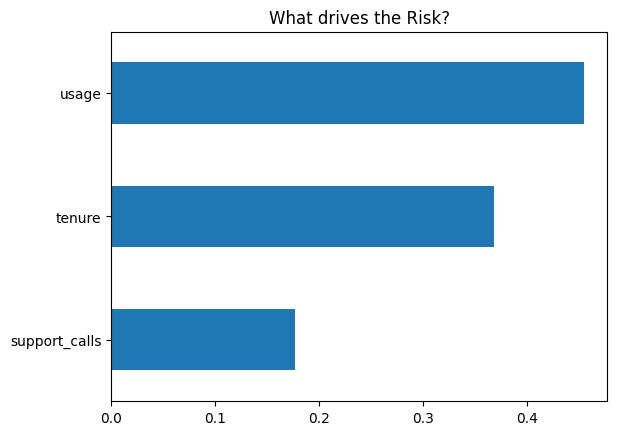

In [46]:
# 2. IMPORTANT: You must FIT the model before it has feature_importances_
best_model_obj.fit(X_train, y_train)

# If the winner was a tree-based model (RF or GradBoost)
if hasattr(best_model_obj, 'feature_importances_'):
    importances = pd.Series(best_model_obj.feature_importances_, index=X.columns)
    importances.sort_values().plot(kind='barh', title='What drives the Risk?')
    plt.show()
